#### Here we run benchmark causal discovery algorithms on the big ER graph and connectome graph.

In [1]:
# 3rd party
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import Notears

# own
import causal_helpers
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrix

2024-06-07 14:56:34,156 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-06-07 14:56:34,203 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
# load the weighted adjacency matrices for ER and connectome

# Specify the folder where the adjacency matrices were saved
folder = './data/'

# Example usage to load the saved adjacency matrices
G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# Change name of the connectome adjacency matrix to C and C_dag
C = G_A_init_t_ordered_adj_matrix
C_dag = G_A_init_t_ordered_dag_adj_matrix

Adjacency matrix loaded from ./data/G_A_init_t_ordered_adj_matrix.npy
Adjacency matrix loaded from ./data/G_A_init_t_ordered_dag_adj_matrix.npy
Adjacency matrix loaded from ./data/ER_adj_matrix.npy
Adjacency matrix loaded from ./data/ER_dag_adj_matrix.npy


In [3]:
# now print the graph name and whether it is a DAG using helper function e.g.: causal_helpers.is_dag(C))
print('C is DAG:', causal_helpers.is_dag(C))
print('C_dag is DAG:', causal_helpers.is_dag(C_dag))
print('ER is DAG:', causal_helpers.is_dag(ER))
print('ER_dag is DAG:', causal_helpers.is_dag(ER_dag))

C is DAG: False
C_dag is DAG: True
ER is DAG: False
ER_dag is DAG: True


In [4]:
# now set seed and create weighted adjacency matrix for ER and C
set_random_seed(0)
n = 1000
sem_type = "gauss"
# ER_dag
ER_w = simulate_parameter(ER_dag)
X_ER = simulate_linear_sem(ER_w, n, sem_type)
# C_dag
C_w = simulate_parameter(C_dag)
X_C = simulate_linear_sem(C_w, n, sem_type)

"""
# now do the same for the cyclic graphs C and ER
# ER
ER_cyclic_w = simulate_parameter(ER)
X_ER_cyclic = simulate_linear_sem_cyclic(ER_cyclic_w, n, sem_type)
# C
C_cyclic_w = simulate_parameter(C)
X_C_cyclic = simulate_linear_sem_cyclic(C_cyclic_w, n, sem_type)
"""

'\n# now do the same for the cyclic graphs C and ER\n# ER\nER_cyclic_w = simulate_parameter(ER)\nX_ER_cyclic = simulate_linear_sem_cyclic(ER_cyclic_w, n, sem_type)\n# C\nC_cyclic_w = simulate_parameter(C)\nX_C_cyclic = simulate_linear_sem_cyclic(C_cyclic_w, n, sem_type)\n'

In [5]:
# simulate data for notears
dataset = IIDSimulation(W=ER_w, n=1000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

# for debugging notears
# create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800
W_true = simulate_parameter(B_true)

# NOTE: you may not write positional arguments after keyword arguments. 
# That is, the values that you are passing positionally have to come first!

# create a dataset using the simulated data
# NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# we should expect to use that many samples actually to be able to learn the graph in a comparable way.
dataset = IIDSimulation(W=W_true, n=1000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

2024-06-07 14:56:34,834 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-07 14:56:34,851 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


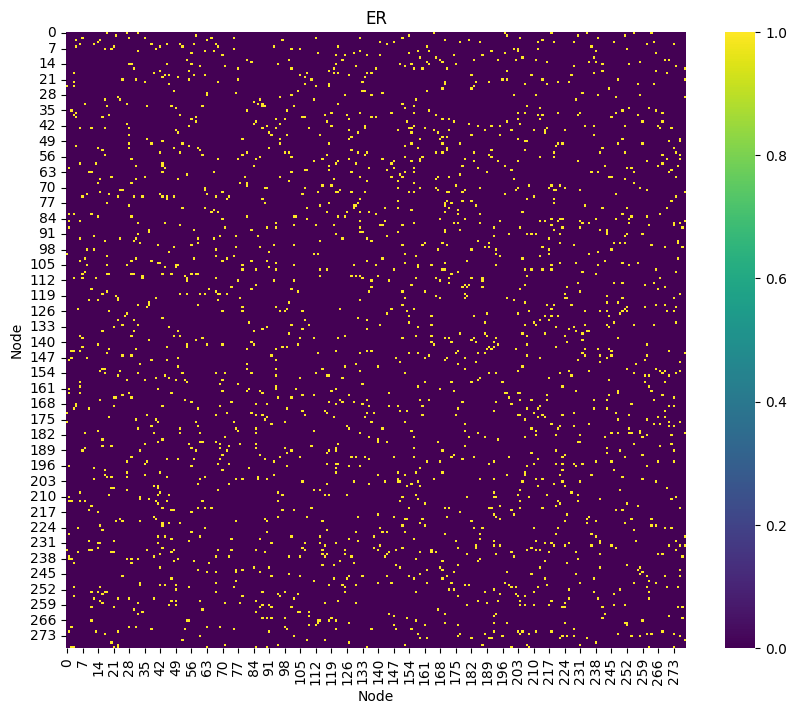

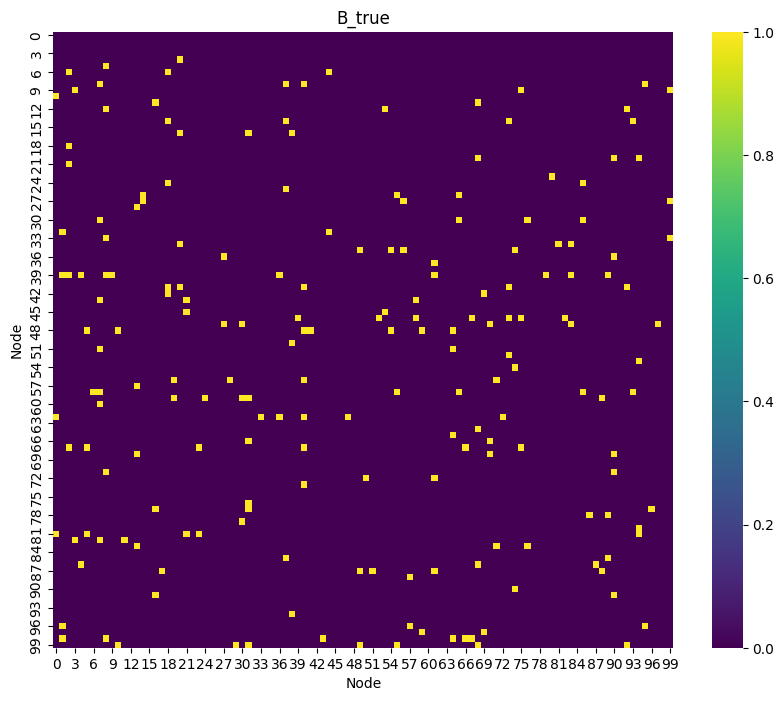

In [6]:
# plot the adjacency matrix of ER and B_true using plot_adjacency_matrix
plot_adjacency_matrix(ER, 'ER')
print()
plot_adjacency_matrix(B_true, 'B_true')

In [7]:
# notears learn
nt = Notears()
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(nt.causal_matrix, true_dag)
print(met.metrics)

2024-06-07 14:56:35,997 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=1000, d=100, iter_=100, h_=1e-08, rho_=1e+16
2024-06-07 15:04:10,362 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=1.895e+00, loss=2915.738, rho=1.0e+00
2024-06-07 15:12:57,201 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=1.184e+00, loss=56.381, rho=1.0e+00
2024-06-07 15:19:30,654 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=5.016e-01, loss=72.535, rho=1.0e+01
2024-06-07 15:29:51,365 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=1.652e-01,

In [ ]:
# simulate data for notears
dataset = IIDSimulation(W=G_A_init_t_ordered_dag_adj_matrix, n=2000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

# notears learn
nt = Notears()
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(nt.causal_matrix, true_dag)
print(met.metrics)

In [ ]:
# show unique values in the dag adjacency matrices
print("The unique values in the ER adjacency matrix are: ", np.unique(ER))
print()
print("The unique values in the ER DAG adjacency matrix are: ", np.unique(ER_dag))

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def adjacency_matrix_to_graph(adj_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
    return G

def inspect_graph_properties(G):
    # Number of nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    # Average degree
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    
    # Degree distribution
    degrees = [d for n, d in G.degree()]
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]
    
    # Check if the graph is a DAG
    is_dag = nx.is_directed_acyclic_graph(G)
    
    # Calculate the density of the graph
    density = nx.density(G)
    
    # Calculate the clustering coefficient
    """
    The clustering coefficient C(v) measures the local density of a node v's neighborhood by 
    comparing the actual number of edges among the neighbors of v to the maximum possible 
    number of edges (k_v*(k_v-1)) for a node with degree k_v in an undirected graph.
    In that sense C(v) is a measure of the cliquishness of the neighborhood of node v.
    For C(v) close to 0, the neighborhood of v is a sparse, disconnected set of nodes.
    For C(v) close to 1, the neighborhood of v is a clique of size k_v (i.e., a complete graph).
    """
    clustering_coefficient = nx.average_clustering(G.to_undirected())
    
    # Print properties
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Is DAG: {is_dag}")
    print(f"Density: {density:.4f}")
    print(f"Average clustering coefficient: {clustering_coefficient:.4f}")
    
    # Plot degree distributions
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.hist(degrees, bins=30, color='skyblue', edgecolor='k', alpha=0.7)
    plt.xlabel('Degree', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Degree Distribution', fontsize=16)
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.hist(in_degrees, bins=30, color='lightcoral', edgecolor='k', alpha=0.7)
    plt.xlabel('In-degree', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('In-degree Distribution', fontsize=16)
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.hist(out_degrees, bins=30, color='lightgreen', edgecolor='k', alpha=0.7)
    plt.xlabel('Out-degree', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Out-degree Distribution', fontsize=16)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Convert the adjacency matrices of ER_dag_adj_matrix and and G_A_init_t_ordered_dag_adj_matrix to graphs
ER_dag_graph = adjacency_matrix_to_graph(ER_dag)
G_A_init_t_ordered_dag_graph = adjacency_matrix_to_graph(G_A_init_t_ordered_dag_adj_matrix)

# Inspect properties of the graphs
print("Properties of ER DAG graph:")
inspect_graph_properties(ER_dag_graph)
print()
print("Properties of G_A_init_t_ordered DAG graph:")
inspect_graph_properties(G_A_init_t_ordered_dag_graph)

In [ ]:
# Convert the adjacency matrices of ER and G_A_init_t_ordered_adj_matrix to graphs
ER_graph = adjacency_matrix_to_graph(ER)
G_A_init_t_ordered_graph = adjacency_matrix_to_graph(G_A_init_t_ordered_adj_matrix)

# Inspect properties of the graphs
print("Properties of ER graph:")
inspect_graph_properties(ER_graph)
print()
print("Properties of G_A_init_t_ordered graph:")
inspect_graph_properties(G_A_init_t_ordered_graph)

In [ ]:
# show unique values in ER_dag and G_A_init_t_ordered_dag_adj_matrix
print("Unique values in ER_dag:", np.unique(ER_dag))
print()
print("Unique values in G_A_init_t_ordered_dag_adj_matrix:", np.unique(G_A_init_t_ordered_dag_adj_matrix))
print()
# now ER and G_A_init_t_ordered_adj_matrix
print("Unique values in ER:", np.unique(ER))
print()
print("Unique values in G_A_init_t_ordered_adj_matrix:", np.unique(G_A_init_t_ordered_adj_matrix))

In [ ]:
# Example usage
folder = './data/'
G_A_init_t_ordered_adj_matrix_binary = np.load(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix_binary.npy'))
G_A_init_t_ordered_dag_adj_matrix_binary = np.load(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix_binary.npy'))

# show unique values in G_A_init_t_ordered_adj_matrix_binary and G_A_init_t_ordered_dag_adj_matrix_binary
print("Unique values in G_A_init_t_ordered_adj_matrix_binary:", np.unique(G_A_init_t_ordered_adj_matrix_binary))
print()
print("Unique values in G_A_init_t_ordered_dag_adj_matrix_binary:", np.unique(G_A_init_t_ordered_dag_adj_matrix_binary))

In [ ]:
plot_adjacency_matrix(G_A_init_t_ordered_adj_matrix_binary, title="G_A_init_t_ordered Binary Adjacency Matrix")
print()
plot_adjacency_matrix(G_A_init_t_ordered_dag_adj_matrix_binary, title="G_A_init_t_ordered DAG Binary Adjacency Matrix")

In [ ]:
# now load the binary upper triangular DAG adjacency matrices for ER and connectome: ER_dag_upper_triangular_binary and G_A_init_t_ordered_dag_upper_triangular_binary
ER_dag_upper_triangular_binary = np.load(os.path.join(folder, 'ER_dag_upper_triangular_binary.npy'))
G_A_init_t_ordered_dag_upper_triangular_binary = np.load(os.path.join(folder, 'G_A_init_t_ordered_dag_upper_triangular_binary.npy'))

In [ ]:
# now plot the permuted DAG adjacency matrices of G_A_init_t_ordered_dag_upper_triangular and ER_dag_upper_triangular
plot_adjacency_matrix(G_A_init_t_ordered_dag_upper_triangular_binary, title="G_A_init_t_ordered DAG Upper Triangular Adjacency Matrix")
print()
plot_adjacency_matrix(ER_dag_upper_triangular_binary, title="ER DAG Upper Triangular Adjacency Matrix")